# Classificação de falhas em placas de aço

No presente trabalho, investigaremos um conjunto de dados que trata do problema de classificação de certos tipos de defeitos e falhas na fabricação de placas de aço. Acreditamos que este dataset tenha sido coletado via um sistema de inspeção de qualidade em linhas de fabricação. <br>

Nossa tarefa aqui é desenvolver um workflow de Ciência de Dados para, em última instância, selecionar um modelo de Machine Learning que faça a classificação automática de tipos de defeitos, baseado em certas features coletadas. Para isso, realizaremos algumas etapas como:

- verificação e possível limpeza dos dados;
- Análise Exploratória;
- treino e validação de diversos modelos de Machine Learning.

O dataset que utilizaremos foi originalmente publicado aqui:
http://archive.ics.uci.edu/dataset/198/steel+plates+faults

Tal projeto foi desenvolvido para a disciplina de Aprendizado de Máquina, ministrada pelo Prof. Edson Cilos, do curso de Matemática na Universidade Federal de Santa Catarina.

# 0. Setup

## 0.1 Imports

In [1]:
import os
import warnings
warnings.filterwarnings('ignore')

# main libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# scikit tools
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# scikit models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import TSNE

## 0.2 Definição dos diretórios

In [2]:
HOME_PATH = os.getcwd()
RAW_DATA_PATH = '/data/raw/'
INTERIM_DATA_PATH = '/data/interim/'

## 0.3 Carregamento dos dados

Vamos coletar os dados via Scikit-learn a partir do repositório de datasets da OpenML. <br>
<br>
Página do dataset na OpenML: https://www.openml.org/search?type=data&status=active&id=1504

In [3]:
steel_plate = fetch_openml(data_id=1504)  

steel_plate_raw = steel_plate.frame
steel_plate_raw.to_csv(HOME_PATH + RAW_DATA_PATH + 'steel_plate_raw.csv')

In [4]:
steel_plate_raw.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V25,V26,V27,V28,V29,V30,V31,V32,V33,Class
0,42,50,270900,270944,267,17,44,24220,76,108,...,0.8182,-0.2913,0.5822,1,0,0,0,0,0,1
1,645,651,2538079,2538108,108,10,30,11397,84,123,...,0.7931,-0.1756,0.2984,1,0,0,0,0,0,1
2,829,835,1553913,1553931,71,8,19,7972,99,125,...,0.6667,-0.1228,0.2150,1,0,0,0,0,0,1
3,853,860,369370,369415,176,13,45,18996,99,126,...,0.8444,-0.1568,0.5212,1,0,0,0,0,0,1
4,1289,1306,498078,498335,2409,60,260,246930,37,126,...,0.9338,-0.1992,1.0000,1,0,0,0,0,0,1


# 0.4 Funções auxiliares

In [94]:
def select_most_relevant_features(X, y, threshold=0.2):
    # informação mútua
    mi_scores = mutual_info_classif(X, y)    
    
    mi_df = pd.DataFrame({
        'feature': X.columns,
        'mutual_info_score': mi_scores
    }).sort_values('mutual_info_score', ascending=False)    
    
    selected_features = mi_df[mi_df['mutual_info_score'] >= threshold]
    
    return mi_df, selected_features['feature'].tolist()

def plot_feature_importance(mi_df, selected_features, figsize=(10, 6), title="Feature Importance (Mutual Information)"):
    
    plt.figure(figsize=figsize)     
    
    colors = ['orangered' if feature in selected_features else 'teal' for feature in mi_df['feature']]    
    
    plt.bar(mi_df['feature'], mi_df['mutual_info_score'], color=colors)    
    
    plt.xticks(rotation=45, ha='right')    
    
    plt.xlabel('Features')
    plt.ylabel('Mutual Information Score')
    plt.title(title)    
    
    plt.tight_layout()
    
    return plt

def plot_manifold_vis(features, palette = 'RdBu_r', figsize=(12, 7.5)):
    tsne_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('dim_reduction', TSNE(perplexity=30))
    ])

    X_embedded_tsne = tsne_pipeline.fit_transform(features)

    plt.figure(figsize=figsize)
    sns.scatterplot(x = X_embedded_tsne[:, 0],
                y = X_embedded_tsne[:, 1],
                hue = steel_plate_train_set['fault_type'], 
                palette = palette                    
                ).set(title='t-SNE Embedding') 

def advanced_feature_visualization(X, y, top_features):
    # cria um grid de subplots
    fig, axes = plt.subplots(
        nrows=len(top_features), 
        ncols=2,         
        figsize=(15, 4*len(top_features))
    )

    color_palette = 'flare'
    
    for i, feature in enumerate(top_features):
        
        sns.boxplot(
            x=y, 
            y=X[feature],
            hue=y, 
            ax=axes[i, 0],
            palette=color_palette,
            legend=False
        )
        axes[i, 0].set_title(f'Box Plot: {feature}')
        
        
        sns.violinplot(
            x=y, 
            y=X[feature],
            hue=y, 
            ax=axes[i, 1],
            palette=color_palette,
            legend=False
        )
        axes[i, 1].set_title(f'Violin Plot: {feature}')
    
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(y_test, pred_y, y):

    class_names = np.unique(np.concatenate((y, y_test)))    
    cm = confusion_matrix(y_test, pred_y, labels=class_names)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

def highlight_max(row):
    is_max = row == row.max()
    return ['background-color: #301934' if v else '' for v in is_max]

def feature_engineering(data):

    # Distâncias dos eixo x e y
    data['X_Distance'] = data['X_Maximum'] - data['X_Minimum']
    data['Y_Distance'] = data['Y_Maximum'] - data['Y_Minimum']

    # Área do retângulo formado pelas distâncias x e y
    data['Rectangle_Area'] = data['X_Distance'] * data['Y_Distance']

    # Razão entre a espessura da placa e a esteira rolante
    data['Ratio_Thickness_Length'] = data['Steel_Plate_Thickness'] / data['Length_of_Conveyer']

    # Diferença de luminosidade
    data['Luminosity_Delta'] = data['Maximum_of_Luminosity'] - data['Minimum_of_Luminosity']

    # Dispersão dos pixels defeituosos ao longo do eixo x
    data['X_Pixels_Range'] = data['Pixels_Areas'] / data['X_Distance']

    return data

# 1. Descrição dos dados

Originalmente, não há uma descritação qualitativa das variáveis no repositório original do dataset. Sendo assim, tivemos que fazer uma breve pesquisa para entender um pouco nossas variáveis. <br>
Segue descrição de algumas das variáveis independentes (features):

- X_Minimum, X_Maximum, Y_Minimum, Y_Maximum: parecem ser coordenadas de uma caixa delimitadora em torno de uma área ou falha detectada na chapa de aço;
- Pixels_Areas: provavelmente o número total de pixels ocupados por uma característica ou região de falha detectada;
- Sum_of_Luminosity, Minimum_of_Luminosity, Maximum_of_Luminosity: estas variáveis descrevem características de intensidade de luz, que podem indicar variações de superfície e possíveis defeitos;
- Length_of_Conveyer: provavelmente relacionado ao comprimento ou posição da linha de produção do transportador;
- TypeOfSteel_A300, TypeOfSteel_A400: variáveis binárias que indicam o tipo de aço utilizado na fabricação da chapa.
- Steel_Plate_Thickness: espessura da placa.

Há outra variáveis que parecem transformações de algumas das anteriores, como: LogOfAreas, Log_X_Index, Log_Y_Index, SigmoidOfAreas etc.

Variáveis alvo (tipos de defeitos/falhas de fabricação):

- Pastry: provavelmente indica uma característica relacionada à aparência ou textura superficial, talvez indique texturas irregulares;
- Z_Scratch: sugere um tipo específico de arranhão ou marca na superfície, quem sabe no formato de uma letra Z;
- K_Scratch (no dataset está escrito 'K_Scatch'): mesmo caso do Z_Scratch, mas possivelmente com uma característica diferente;
- Stains: manchas ou descolorações na superfície da placa;
- Dirtiness: sujeira ou contaminação na placa;
- Bumps: saliências ou protuberâncias na superfície;
- Other_Faults: categoria genérica para englobar defeitos que não sejam de nenhum tipo acima.

Dadas as características das variáveis, conjecturamos que as features (ou pelo menos algumas delas) foram capturadas utilizando-se técnicas de visão computacional.

Abaixo, como os nomes atuais das colunas não nos dizem muita coisa, vamos renomeá-las para facilitar nosso trabalho.

In [6]:
columns_names = [
    'X_Minimum', 'X_Maximum', 'Y_Minimum', 'Y_Maximum', 'Pixels_Areas', 
    'X_Perimeter', 'Y_Perimeter', 'Sum_of_Luminosity', 'Minimum_of_Luminosity', 
    'Maximum_of_Luminosity', 'Length_of_Conveyer', 'TypeOfSteel_A300', 
    'TypeOfSteel_A400', 'Steel_Plate_Thickness', 'Edges_Index', 'Empty_Index', 
    'Square_Index', 'Outside_X_Index', 'Edges_X_Index', 'Edges_Y_Index', 
    'Outside_Global_Index', 'LogOfAreas', 'Log_X_Index', 'Log_Y_Index', 
    'Orientation_Index', 'Luminosity_Index', 'SigmoidOfAreas', 'Pastry', 
    'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults'
]

steel_plate_raw.columns = columns_names

In [7]:
steel_plate_raw

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,...,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,42,50,270900,270944,267,17,44,24220,76,108,...,0.8182,-0.2913,0.5822,1,0,0,0,0,0,1
1,645,651,2538079,2538108,108,10,30,11397,84,123,...,0.7931,-0.1756,0.2984,1,0,0,0,0,0,1
2,829,835,1553913,1553931,71,8,19,7972,99,125,...,0.6667,-0.1228,0.2150,1,0,0,0,0,0,1
3,853,860,369370,369415,176,13,45,18996,99,126,...,0.8444,-0.1568,0.5212,1,0,0,0,0,0,1
4,1289,1306,498078,498335,2409,60,260,246930,37,126,...,0.9338,-0.1992,1.0000,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1936,249,277,325780,325796,273,54,22,35033,119,141,...,-0.4286,0.0026,0.7254,0,0,0,0,0,0,2
1937,144,175,340581,340598,287,44,24,34599,112,133,...,-0.4516,-0.0582,0.8173,0,0,0,0,0,0,2
1938,145,174,386779,386794,292,40,22,37572,120,140,...,-0.4828,0.0052,0.7079,0,0,0,0,0,0,2
1939,137,170,422497,422528,419,97,47,52715,117,140,...,-0.0606,-0.0171,0.9919,0,0,0,0,0,0,2


## 1.1 Colunas, dtypes, forma e NaNs.

In [8]:
steel_plate_raw.shape

(1941, 34)

In [9]:
steel_plate_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1941 entries, 0 to 1940
Data columns (total 34 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   X_Minimum              1941 non-null   int64   
 1   X_Maximum              1941 non-null   int64   
 2   Y_Minimum              1941 non-null   int64   
 3   Y_Maximum              1941 non-null   int64   
 4   Pixels_Areas           1941 non-null   int64   
 5   X_Perimeter            1941 non-null   int64   
 6   Y_Perimeter            1941 non-null   int64   
 7   Sum_of_Luminosity      1941 non-null   int64   
 8   Minimum_of_Luminosity  1941 non-null   int64   
 9   Maximum_of_Luminosity  1941 non-null   int64   
 10  Length_of_Conveyer     1941 non-null   int64   
 11  TypeOfSteel_A300       1941 non-null   int64   
 12  TypeOfSteel_A400       1941 non-null   int64   
 13  Steel_Plate_Thickness  1941 non-null   int64   
 14  Edges_Index            1941 non-null   f

Como podemos ver, não há nenhum dado faltante em nenhuma coluna. Também notamos que há somente variáveis numéricas em nosso conjunto de dados, a menos da variável 'Other_Faults'. <br> Faremos a transformação apropriada desta em um momento posterior.

## 1.2 Distribuição de classes (tipos de falha)

In [10]:
fault_types = ['Pastry','Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults']

for fault in fault_types:

    if fault == 'Other_Faults':

        fault_df = steel_plate_raw.loc[steel_plate_raw['Other_Faults'] == '2']        
        fault_sample_size = fault_df.shape[0]

        print("Número de amostras para " + fault + " é de " + str(fault_sample_size))

    else:
        fault_df = steel_plate_raw.loc[steel_plate_raw[fault] == 1]
        fault_sample_size = fault_df.shape[0]

        print("Número de amostras para a falha " + fault + " é " + str(fault_sample_size))  

Número de amostras para a falha Pastry é 158
Número de amostras para a falha Z_Scratch é 190
Número de amostras para a falha K_Scatch é 391
Número de amostras para a falha Stains é 72
Número de amostras para a falha Dirtiness é 55
Número de amostras para a falha Bumps é 402
Número de amostras para Other_Faults é de 673


Notamos aqui um desbalanceamento na distribuição de falhas no conjunto todo. Isto será levado em conta na etapa seguinte.

# 2. Separação do conjunto de teste

In [11]:
steel_plate_interim = steel_plate_raw.copy()
steel_plate_interim.to_csv(HOME_PATH + INTERIM_DATA_PATH + 'steel_plate_interim.csv')

Antes de passarmos à nossa análise exploratória, vamos separar um subconjunto do nosso dataset para conjunto de teste. Como queremos evitar viés no modelo de classificação, faremos essa divisão de forma estratificada. <br>
Para isso, criaremos uma nova coluna para codificar os tipos de falha em termos de multiclasses e não onehot. Vamos aproveitar também para fazer uma mudança na coluna 'Other_faults' a fim de colocá-la no mesmo formato das outras. 

In [12]:
steel_plate_interim['Other_Faults'] = steel_plate_interim['Other_Faults'].map({'1': 0, '2': 1}).astype('int64')
var_type = steel_plate_interim['Other_Faults'].dtype
new_values = steel_plate_interim['Other_Faults'].unique()

print('O novo tipo da coluna Other_Faults é: ' + str(var_type))
print('Com novos valores ' + str(new_values[0]) + ' e ' + str(new_values[1]))

O novo tipo da coluna Other_Faults é: int64
Com novos valores 0 e 1


Criamos aqui uma coluna com as diferentes classes.

In [13]:
steel_plate_interim['fault_type'] = steel_plate_interim[fault_types].apply(lambda row: row[row == 1].index[0], axis=1)

print('Conferindo as classes da nova coluna: ' + str(steel_plate_interim['fault_type'].unique()))

Conferindo as classes da nova coluna: ['Pastry' 'Z_Scratch' 'K_Scatch' 'Stains' 'Dirtiness' 'Bumps'
 'Other_Faults']


Feitas as transformações necessárias, passamos à divisão do dataset.

In [14]:
seed = 42

steel_plate_train_set, test_set = train_test_split(steel_plate_interim,
                                                   random_state= seed,
                                                   test_size=0.1,
                                                   stratify=steel_plate_interim['fault_type'])

steel_plate_train_set.to_csv(HOME_PATH + INTERIM_DATA_PATH + 'steel_plate_train_set.csv')

In [15]:
for fault in test_set['fault_type'].unique():
    n_amostras = test_set.loc[test_set['fault_type'] == fault].shape[0]
    print("Número de amostras no conjunto de teste para a falha " + str(fault) + " é " + str(n_amostras))

Número de amostras no conjunto de teste para a falha Bumps é 40
Número de amostras no conjunto de teste para a falha Other_Faults é 68
Número de amostras no conjunto de teste para a falha Pastry é 16
Número de amostras no conjunto de teste para a falha K_Scatch é 39
Número de amostras no conjunto de teste para a falha Z_Scratch é 19
Número de amostras no conjunto de teste para a falha Dirtiness é 6
Número de amostras no conjunto de teste para a falha Stains é 7


Como queríamos, temos uma amostra estratificada como teste.

# 3. Análise exploratória

Passaremos agora ao estudo do dataset, buscando informações como:

- distribuição das variáveis;
- possíveis correlações entre elas;
- padrões e insights que possam nos ajudar a selecionar os modelos.

## 3.1 Métricas descritivas

In [16]:
steel_plate_features = steel_plate_train_set.drop(fault_types + ['fault_type'], axis=1)

descriptive_stats = steel_plate_features.describe().T
descriptive_stats['skewness'] = steel_plate_features.skew()
descriptive_stats['kurtosis'] = steel_plate_features.kurtosis()

column_order = ['count', 'mean', 'std', 'skewness', 'kurtosis', 'min', '25%', '50%', '75%', 'max']
descriptive_stats = descriptive_stats[column_order]

descriptive_stats

,count,mean,std,skewness,kurtosis,min,25%,50%,75%,max
X_Minimum,1746.0,5.689255e+02,5.199416e+02,0.514565,-1.128779,0.0000,53.000000,4.220000e+02,1.052500e+03,1.705000e+03
X_Maximum,1746.0,6.159685e+02,4.968146e+02,0.540588,-1.060164,4.0000,193.000000,4.615000e+02,1.072500e+03,1.713000e+03
Y_Minimum,1746.0,1.656829e+06,1.795081e+06,2.819467,11.263411,6712.0000,468485.500000,1.197207e+06,2.182434e+06,1.298766e+07
Y_Maximum,1746.0,1.656884e+06,1.795094e+06,2.819419,11.263004,6724.0000,468645.750000,1.197316e+06,2.182443e+06,1.298769e+07
Pixels_Areas,1746.0,1.936229e+03,5.348425e+03,14.058609,363.856065,2.0000,84.250000,1.755000e+02,8.375000e+02,1.526550e+05
X_Perimeter,1746.0,1.133373e+02,3.119704e+02,21.484958,691.289902,2.0000,15.000000,2.700000e+01,8.775000e+01,1.044900e+04
Y_Perimeter,1746.0,8.456816e+01,4.483549e+02,37.588537,1513.381801,1.0000,13.000000,2.500000e+01,8.300000e+01,1.815200e+04
Sum_of_Luminosity,1746.0,2.110558e+05,5.278428e+05,7.761215,129.260397,250.0000,9556.750000,1.945850e+04,8.444825e+04,1.159141e+07
Minimum_of_Luminosity,1746.0,8.445189e+01,3.232988e+01,-0.107592,0.091887,0.0000,63.000000,9.000000e+01,1.060000e+02,2.030000e+02
Maximum_of_Luminosity,1746.0,1.302068e+02,1.856917e+01,1.220212,7.638648,37.0000,124.000000,1.270000e+02,1.400000e+02,2.530000e+02


## 3.2 Análise de correlações

Dado o grande número de features em nosso dataset, a análise dos dados via visualizações, sobre todas as variáveis, fica inviável. Por exemplo, se fôssemos plotar todos os gráficos de dispersão bivariados, teríamos 28²/2 plots a analisar (só para as features). Sendo assim, começaremos por uma análise de correlação entre variáveis, a fim de potencialmente selecionarmos as features mais relevantes para nosso problema, e então passar para uma análise mais detalhada sobre tais.

Vamos primeiro plotar uma matriz de correlações entre as features.

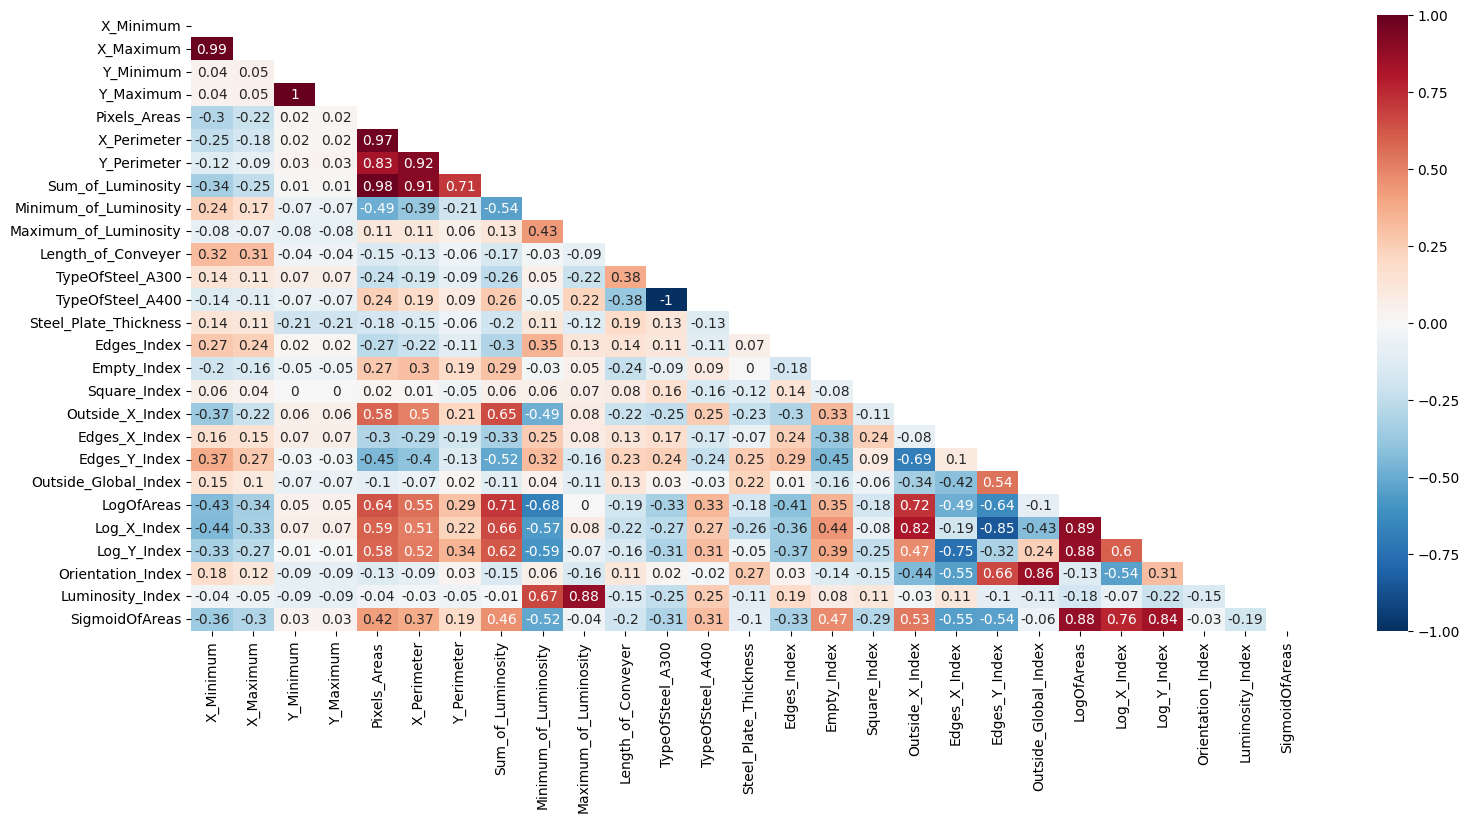

In [17]:
corr_matrix = steel_plate_features.corr()
corr_matrix = round(corr_matrix, 2)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

fig, ax = plt.subplots(1, 1, figsize=(18, 8))
sns.heatmap(corr_matrix,
            vmin=-1,
            vmax=1,
            cmap='RdBu_r',
            annot=True,
            ax=ax,
            mask=mask)
plt.show()

Note a forte correlação entre algumas de nossas features, por exemplo, X_Maximum e X_Minimum. Isto pode ser um indicativo de que não precisamos manter as duas para o treino do modelo. Seguiremos com mais alguns testes.


Abaixo, vamos realizar o teste de Informação Mútua. Em poucas palavras, este teste mede o quanto de informação podemos inferir sobre uma variável aleatória X observando uma outra variável aleatória Y. No nosso contexto, vamos performar o teste entre a variável alvo e as diferentes features. Além disso, nossa função retorna uma lista de features com score de MI acima de um dado limiar (default=0.2).

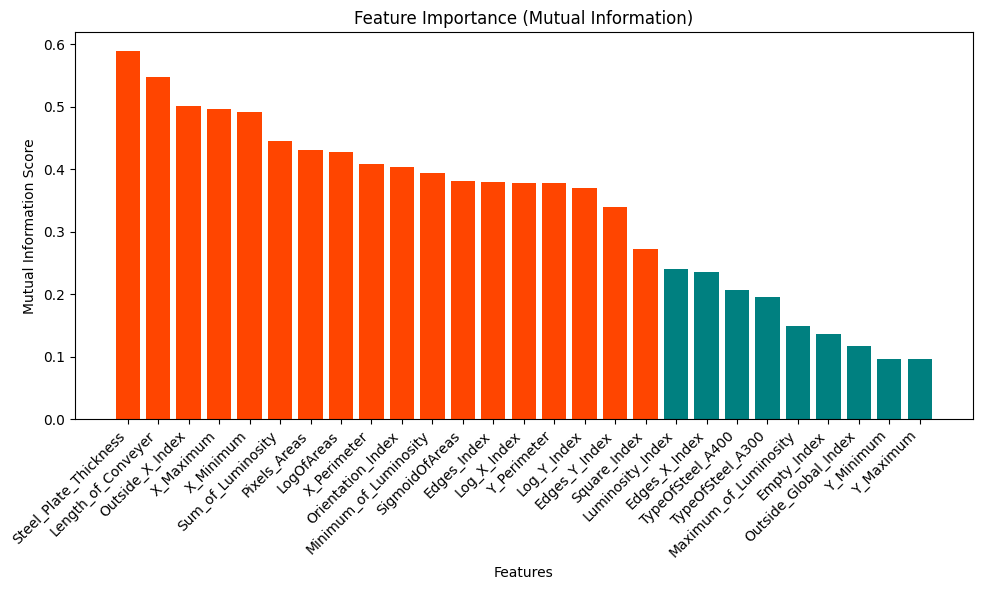

In [18]:
mi_threshold = 0.25

mutual_info_df, mutual_info_list = select_most_relevant_features(steel_plate_features, steel_plate_train_set['fault_type'], threshold=mi_threshold)

plot = plot_feature_importance(mutual_info_df, mutual_info_list)
plot.show()

## 3.3 Visualizações univariadas

Abaixo, plotamos gráficos de caixa e violino para os n top features da lista retornada acima.

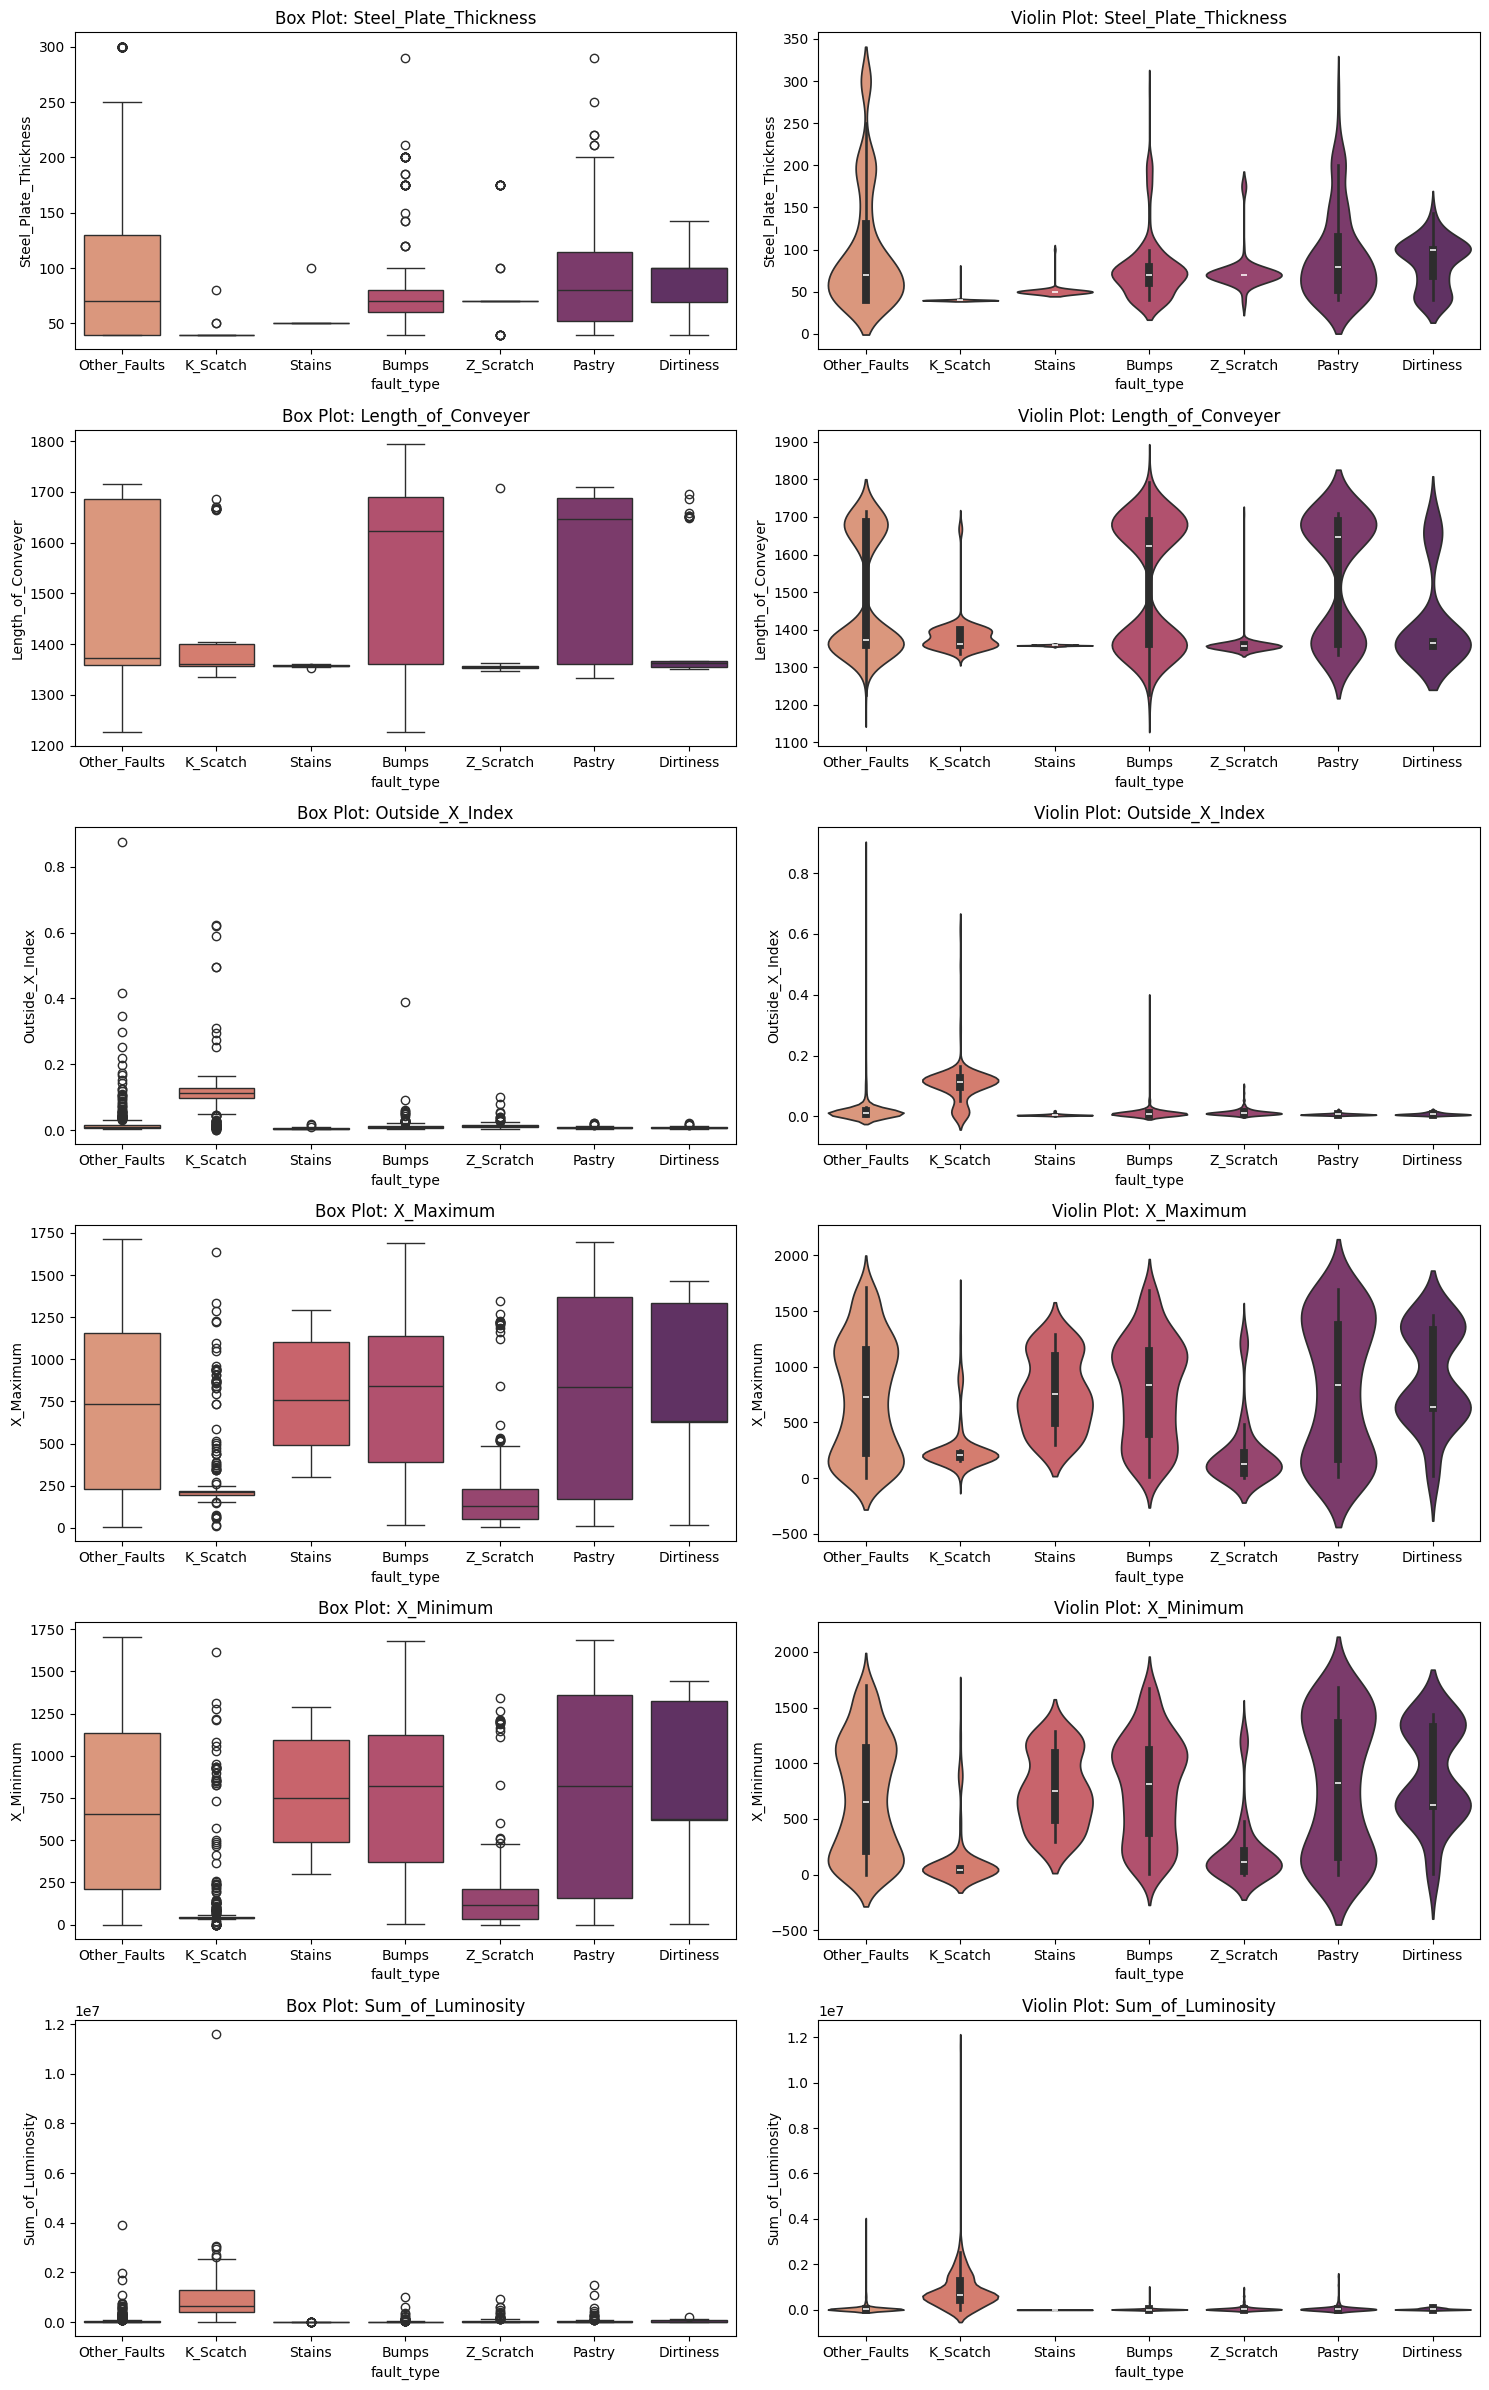

In [19]:
top_n_features = 6

advanced_feature_visualization(steel_plate_features, steel_plate_train_set['fault_type'], mutual_info_list[:top_n_features])

Como indicado pelo teste, vemos que há uma mudança significativa na distribuição destas variáveis entre as 7 diferentes classes. Isto nos sugere que tais variáveis são bons preditores (features) para nossos modelos.

## 3.3 Visualização via embeddings

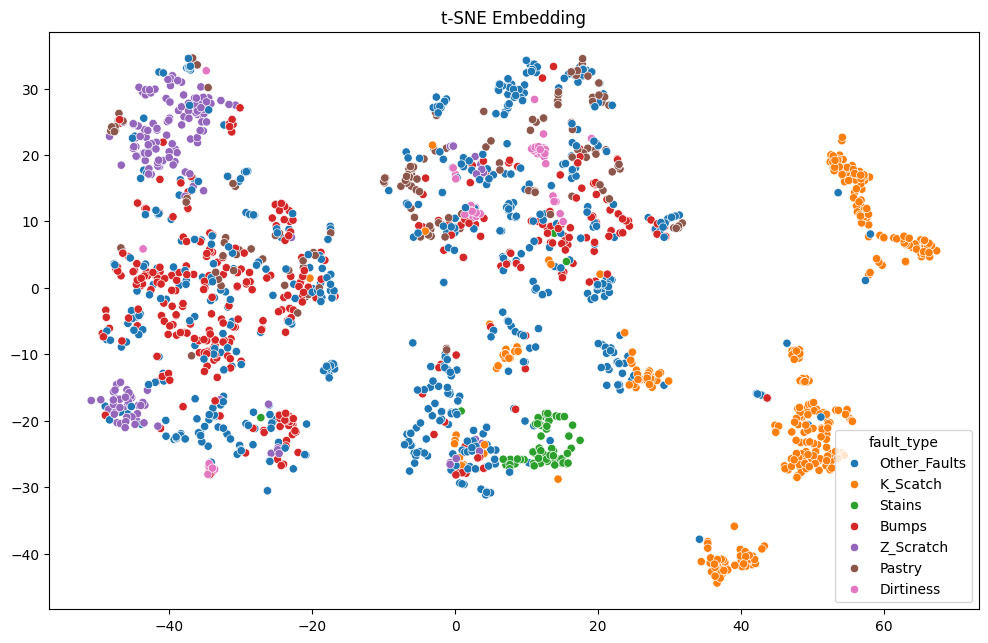

In [95]:
plot_manifold_vis(steel_plate_features, palette='tab10')

Da visualização acima, vemos que há classes consideravelmente mais separáveis que outras. Por exemplo, as classes K_Scatch e Stains parece estar bem distantes da classe Z_Scratch. <br>
Porém note que isso já não ocorre para Other_Faults, que parece se confundir principalmente com a classe Bumps e Pastry.

# 4. Modelos

Neste ponto, faremos Grid Search sobre 5 modelos selecionados:

- Regressão Logística;
- SVC;
- KNN;
- Árvore de Decisão (CART);
- Random Forest.

Como nosso conjunto de dados é desbalanceado em relação aos targets, escolhemos 'balanced acurracy' como nossa métrica de avaliação para o Grid Search. <br> Além disso, testaremos tais modelos sobre três conjuntos diferentes de features. Abaixo, segue o primeiro.


## 4.1 Com todas as features 

In [21]:
model_and_score_all_features = []

X_train = steel_plate_features
y_train = steel_plate_train_set['fault_type']

stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

### 4.1.1 Regressão Logística

In [22]:
logistic_pipeline = Pipeline([
    ('scaler', ()),
    ('classifier', LogisticRegression(solver='liblinear', max_iter=1000, random_state=seed))
])

param_grid = {
    'scaler': [StandardScaler(), MinMaxScaler(), None],  
    'classifier__C': [0.01, 0.1, 1, 10], 
    'classifier__penalty': ['l1', 'l2'],
}

grid_search = GridSearchCV(estimator=logistic_pipeline,
                           param_grid=param_grid,
                           cv=stratified_cv, 
                           scoring='balanced_accuracy',
                           verbose=1)

grid_search.fit(X_train, y_train)

model_and_score_all_features.append([grid_search.best_estimator_, grid_search.best_score_])

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters: {'classifier__C': 10, 'classifier__penalty': 'l1', 'scaler': StandardScaler()}
Best cross-validation score: 0.711591971575732


### 4.1.2 SVC

In [23]:
svc_pipeline = Pipeline([
    ('scaler', ()),
    ('classifier', SVC(class_weight='balanced', random_state=seed))
])

param_grid = {     
    'scaler': [StandardScaler(), MinMaxScaler()],
    'classifier__kernel': ['rbf', 'linear'],    
    'classifier__C': [0.1, 1, 10, 100],                
    'classifier__gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1]   
}

grid_search = GridSearchCV(estimator=svc_pipeline,
                           param_grid=param_grid,
                           cv=stratified_cv, 
                           scoring='balanced_accuracy',
                           verbose=1)

grid_search.fit(X_train, y_train)
model_and_score_all_features.append([grid_search.best_estimator_, grid_search.best_score_])

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best parameters: {'classifier__C': 10, 'classifier__gamma': 'scale', 'classifier__kernel': 'rbf', 'scaler': StandardScaler()}
Best cross-validation score: 0.8042251644627795


### 4.1.3 KNN

In [24]:
knn_pipeline = Pipeline([
    ('scaler', ()),
    ('classifier', KNeighborsClassifier())
])

param_grid = {
    'scaler': [StandardScaler(), MinMaxScaler()],   
    'classifier__n_neighbors': [3, 5, 7, 9, 11, 15, 20],   
    'classifier__weights': ['uniform', 'distance'],         
    'classifier__metric': ['euclidean', 'manhattan', 'minkowski'],  
    'classifier__p': [1, 2]                                 
}

grid_search = GridSearchCV(estimator=knn_pipeline,
                           param_grid=param_grid,
                           cv=stratified_cv, 
                           scoring='balanced_accuracy',
                           verbose=1)

grid_search.fit(X_train, y_train)
model_and_score_all_features.append([grid_search.best_estimator_, grid_search.best_score_])

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

Fitting 5 folds for each of 168 candidates, totalling 840 fits
Best parameters: {'classifier__metric': 'manhattan', 'classifier__n_neighbors': 5, 'classifier__p': 1, 'classifier__weights': 'distance', 'scaler': StandardScaler()}
Best cross-validation score: 0.7827619451640755


### 4.1.4 CART

In [25]:
cart_model = DecisionTreeClassifier(random_state=seed)

param_grid = {
    'criterion': ['gini', 'entropy'],          
    'max_depth': [None, 5, 10, 15, 20],        
    'min_samples_split': [2, 5, 10, 20],       
    'min_samples_leaf': [1, 5, 10, 20],        
    'max_features': [None, 'sqrt', 'log2'],    
    'class_weight': [None, 'balanced']         
}

grid_search = GridSearchCV(estimator=cart_model,
                           param_grid=param_grid,
                           cv=stratified_cv, 
                           scoring='balanced_accuracy',
                           verbose=1)

grid_search.fit(X_train, y_train)
model_and_score_all_features.append([grid_search.best_estimator_, grid_search.best_score_])

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

Fitting 5 folds for each of 960 candidates, totalling 4800 fits
Best parameters: {'class_weight': None, 'criterion': 'entropy', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best cross-validation score: 0.7628483866050837


### 4.1.5 Random Forest

In [26]:
rf_model = RandomForestClassifier(class_weight='balanced',random_state=seed)

param_grid = {
    'n_estimators': [200, 250, 300],         
    'criterion': ['gini', 'entropy'],       
    'max_depth': [None, 8],        
    'min_samples_split': [2, 5],        
    'min_samples_leaf': [1, 2],          
    'max_features': ['sqrt', None]    
}

grid_search = GridSearchCV(estimator=rf_model,
                           param_grid=param_grid,
                           cv=stratified_cv, 
                           scoring='balanced_accuracy',
                           verbose=1)

grid_search.fit(X_train, y_train)
model_and_score_all_features.append([grid_search.best_estimator_, grid_search.best_score_])

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best parameters: {'criterion': 'entropy', 'max_depth': 8, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Best cross-validation score: 0.8130627496363237


## 4.2 Com seleção de features

Baseado na nossa análise exploratória, vamos remover algumas features do conjunto de treino. <br>
Foram usados critérios como: 
- alta correlação com alguma outra variável;
- baixo coeficiente MI.

 Como exemplo, excluímos uma das variáveis de tipo de aço (TypeOfSteel_A400), já que ela é mutuamente excludente em relação à outra (TypeOfSteel_A300).

In [28]:
model_and_score_selected_features = []

features_to_drop = ['Y_Minimum','X_Minimum', 'X_Perimeter', 'Sum_of_Luminosity', 'Edges_X_Index',
                    'SigmoidOfAreas', 'Luminosity_Index', 'TypeOfSteel_A400', 'Outside_Global_Index','Empty_Index', 'Square_Index']

X_train = steel_plate_features.drop(features_to_drop, axis=1)
y_train = steel_plate_train_set['fault_type']

### 4.2.1 Regressão Logística

In [29]:
logistic_pipeline = Pipeline([
    ('scaler', ()),
    ('classifier', LogisticRegression(solver='liblinear', max_iter=1000, random_state=seed))
])

param_grid = {
    'scaler': [StandardScaler(), MinMaxScaler(), None],  
    'classifier__C': [0.01, 0.1, 1, 10], 
    'classifier__penalty': ['l1', 'l2'],
}

grid_search = GridSearchCV(estimator=logistic_pipeline,
                           param_grid=param_grid,
                           cv=stratified_cv, 
                           scoring='balanced_accuracy',
                           verbose=1)

grid_search.fit(X_train, y_train)
model_and_score_selected_features.append([grid_search.best_estimator_, grid_search.best_score_])

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters: {'classifier__C': 10, 'classifier__penalty': 'l1', 'scaler': StandardScaler()}
Best cross-validation score: 0.6750272989718346


### 4.2.2 SVC

In [30]:
svc_pipeline = Pipeline([
    ('scaler', ()),
    ('classifier', SVC(class_weight='balanced', random_state=seed))
])

param_grid = {     
    'scaler': [StandardScaler(), MinMaxScaler()],
    'classifier__kernel': ['rbf', 'linear'],    
    'classifier__C': [0.1, 1, 10, 100],                
    'classifier__gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1]   
}

grid_search = GridSearchCV(estimator=svc_pipeline,
                           param_grid=param_grid,
                           cv=stratified_cv, 
                           scoring='balanced_accuracy',
                           verbose=1)

grid_search.fit(X_train, y_train)
model_and_score_selected_features.append([grid_search.best_estimator_, grid_search.best_score_])

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best parameters: {'classifier__C': 10, 'classifier__gamma': 'scale', 'classifier__kernel': 'rbf', 'scaler': StandardScaler()}
Best cross-validation score: 0.8235393532400481


### 4.2.3 KNN

In [31]:
knn_pipeline = Pipeline([
    ('scaler', ()),
    ('classifier', KNeighborsClassifier())
])

param_grid = {
    'scaler': [StandardScaler(), MinMaxScaler()],   
    'classifier__n_neighbors': [3, 5, 7, 9, 11, 15, 20],   
    'classifier__weights': ['uniform', 'distance'],         
    'classifier__metric': ['euclidean', 'manhattan', 'minkowski'],  
    'classifier__p': [1, 2]                                 
}

grid_search = GridSearchCV(estimator=knn_pipeline,
                           param_grid=param_grid,
                           cv=stratified_cv, 
                           scoring='balanced_accuracy',
                           verbose=1)

grid_search.fit(X_train, y_train)
model_and_score_selected_features.append([grid_search.best_estimator_, grid_search.best_score_])

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

Fitting 5 folds for each of 168 candidates, totalling 840 fits
Best parameters: {'classifier__metric': 'manhattan', 'classifier__n_neighbors': 5, 'classifier__p': 1, 'classifier__weights': 'distance', 'scaler': StandardScaler()}
Best cross-validation score: 0.7961969234044602


### 4.2.4 CART

In [32]:
cart_model = DecisionTreeClassifier(random_state=seed)

param_grid = {
    'criterion': ['gini', 'entropy'],          
    'max_depth': [None, 5, 10, 15, 20],        
    'min_samples_split': [2, 5, 10, 20],       
    'min_samples_leaf': [1, 5, 10, 20],        
    'max_features': [None, 'sqrt', 'log2'],    
    'class_weight': [None, 'balanced']         
}

grid_search = GridSearchCV(estimator=cart_model,
                           param_grid=param_grid,
                           cv=stratified_cv, 
                           scoring='balanced_accuracy',
                           verbose=1)

grid_search.fit(X_train, y_train)
model_and_score_selected_features.append([grid_search.best_estimator_, grid_search.best_score_])

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

Fitting 5 folds for each of 960 candidates, totalling 4800 fits
Best parameters: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5}
Best cross-validation score: 0.7765585291989863


### 4.2.5 Random Forest

In [33]:
rf_model = RandomForestClassifier(class_weight='balanced',random_state=seed)

param_grid = {
    'n_estimators': [200, 250, 280],         
    'criterion': ['gini', 'entropy'],       
    'max_depth': [None, 8],        
    'min_samples_split': [2, 5],        
    'min_samples_leaf': [1, 2],          
    'max_features': ['sqrt', None]    
}

grid_search = GridSearchCV(estimator=rf_model,
                           param_grid=param_grid,
                           cv=stratified_cv, 
                           scoring='balanced_accuracy',
                           verbose=1)

grid_search.fit(X_train, y_train)
model_and_score_selected_features.append([grid_search.best_estimator_, grid_search.best_score_])

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best parameters: {'criterion': 'entropy', 'max_depth': 8, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Best cross-validation score: 0.8290674980282352


## 4.3 Com engenharia de features

Aqui, criamos algumas variáveis que julgamos que podem fazer sentido/ajudar o modelo a classificar corretamente os tipos de falha. São estas:

- X_Distance: diferença entre X_Minimum e X_Maximum;
- Y_Distance: diferença entre Y_Minimum e Y_Maximum;
- Rectangle_Area: área do retângulo definido pelas variáveis X_Distance e Y_Distance;
- Ratio_Thickness_Length: razão entre a espessura da placa e comprimento da esteira rolante;
- Luminosity_Delta: diferença de luminosidade;
- X_Pixels_Range: dispersão dos pixels defeituosos ao longo do eixo x.

In [35]:
model_and_score_feature_engineering = []

X_train = feature_engineering(steel_plate_features.copy())
X_train = X_train.drop(features_to_drop, axis=1)

y_train = steel_plate_train_set['fault_type']

### 4.3.1 Regressão Logística

In [36]:
logistic_pipeline = Pipeline([
    ('scaler', ()),
    ('classifier', LogisticRegression(solver='liblinear', max_iter=1000, random_state=seed))
])

param_grid = {
    'scaler': [StandardScaler(), MinMaxScaler(), None],  
    'classifier__C': [0.01, 0.1, 1, 10], 
    'classifier__penalty': ['l1', 'l2'],
}

grid_search = GridSearchCV(estimator=logistic_pipeline,
                           param_grid=param_grid,
                           cv=stratified_cv, 
                           scoring='balanced_accuracy',
                           verbose=1)

grid_search.fit(X_train, y_train)
model_and_score_feature_engineering.append([grid_search.best_estimator_, grid_search.best_score_])

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters: {'classifier__C': 10, 'classifier__penalty': 'l1', 'scaler': StandardScaler()}
Best cross-validation score: 0.6841894056481802


### 4.3.2 SVC

In [37]:
svc_pipeline = Pipeline([
    ('scaler', ()),
    ('classifier', SVC(class_weight='balanced', random_state=seed))
])

param_grid = {     
    'scaler': [StandardScaler(), MinMaxScaler()],
    'classifier__kernel': ['rbf', 'linear'],    
    'classifier__C': [0.1, 1, 10, 100],                
    'classifier__gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1]   
}

grid_search = GridSearchCV(estimator=svc_pipeline,
                           param_grid=param_grid,
                           cv=stratified_cv, 
                           scoring='balanced_accuracy',
                           verbose=1)

grid_search.fit(X_train, y_train)
model_and_score_feature_engineering.append([grid_search.best_estimator_, grid_search.best_score_])

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best parameters: {'classifier__C': 10, 'classifier__gamma': 'scale', 'classifier__kernel': 'rbf', 'scaler': StandardScaler()}
Best cross-validation score: 0.8253701738001429


### 4.3.3 KNN

In [38]:
knn_pipeline = Pipeline([
    ('scaler', ()),
    ('classifier', KNeighborsClassifier())
])

param_grid = {
    'scaler': [StandardScaler(), MinMaxScaler()],   
    'classifier__n_neighbors': [3, 5, 7, 9, 11, 15, 20],   
    'classifier__weights': ['uniform', 'distance'],         
    'classifier__metric': ['euclidean', 'manhattan', 'minkowski'],  
    'classifier__p': [1, 2]                                 
}

grid_search = GridSearchCV(estimator=knn_pipeline,
                           param_grid=param_grid,
                           cv=stratified_cv, 
                           scoring='balanced_accuracy',
                           verbose=1)

grid_search.fit(X_train, y_train)
model_and_score_feature_engineering.append([grid_search.best_estimator_, grid_search.best_score_])

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

Fitting 5 folds for each of 168 candidates, totalling 840 fits
Best parameters: {'classifier__metric': 'manhattan', 'classifier__n_neighbors': 3, 'classifier__p': 1, 'classifier__weights': 'distance', 'scaler': MinMaxScaler()}
Best cross-validation score: 0.8004668265718082


### 4.3.4 CART

In [39]:
cart_model = DecisionTreeClassifier(random_state=seed)

param_grid = {
    'criterion': ['gini', 'entropy'],          
    'max_depth': [None, 5, 10, 15, 20],        
    'min_samples_split': [2, 5, 10, 20],       
    'min_samples_leaf': [1, 5, 10, 20],        
    'max_features': [None, 'sqrt', 'log2'],    
    'class_weight': [None, 'balanced']         
}

grid_search = GridSearchCV(estimator=cart_model,
                           param_grid=param_grid,
                           cv=stratified_cv, 
                           scoring='balanced_accuracy',
                           verbose=1)

grid_search.fit(X_train, y_train)
model_and_score_feature_engineering.append([grid_search.best_estimator_, grid_search.best_score_])

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

Fitting 5 folds for each of 960 candidates, totalling 4800 fits
Best parameters: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 5, 'min_samples_split': 2}
Best cross-validation score: 0.7788755367081993


### 4.3.5 Random Forest

In [40]:
rf_model = RandomForestClassifier(class_weight='balanced',random_state=seed)

param_grid = {
    'n_estimators': [150, 200, 250],         
    'criterion': ['gini', 'entropy'],       
    'max_depth': [None, 8],        
    'min_samples_split': [2, 5],        
    'min_samples_leaf': [1, 2],          
    'max_features': ['sqrt', None]    
}

grid_search = GridSearchCV(estimator=rf_model,
                           param_grid=param_grid,
                           cv=stratified_cv, 
                           scoring='balanced_accuracy',
                           verbose=1)

grid_search.fit(X_train, y_train)
model_and_score_feature_engineering.append([grid_search.best_estimator_, grid_search.best_score_])

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best parameters: {'criterion': 'entropy', 'max_depth': 8, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 150}
Best cross-validation score: 0.8308662907944135


## 4.4 Comparação dos modelos

In [64]:
model_list = ['LogReg', 'SVC', 'KNN', 'CART', 'RandomForest']

scores_all_features = [ele[1] for ele in model_and_score_all_features]
scores_selected_features = [ele[1] for ele in model_and_score_selected_features]
scores_all_feature_engineering = [ele[1] for ele in model_and_score_feature_engineering]

comparison_dict = {'ScoreTodosOsFeatures': scores_all_features,
                   'ScoreFeaturesSelecionados': scores_selected_features,
                   'ScoreFeatureEngineering': scores_all_feature_engineering}

comparison_df = pd.DataFrame(comparison_dict, index=model_list)

In [65]:
styled_df = comparison_df.style.apply(highlight_max, axis=1)
styled_df

,ScoreTodosOsFeatures,ScoreFeaturesSelecionados,ScoreFeatureEngineering
LogReg,0.711592,0.675027,0.684189
SVC,0.804225,0.823539,0.825370
KNN,0.782762,0.796197,0.800467
CART,0.762848,0.776559,0.778876
RandomForest,0.813063,0.829067,0.830866


Como vemos acima, fora a Regressão Logística, todos os modelos parecem ter performado melhor com a engenharia de features - porém, vale notar que tal diferença parece ser insignificante em relação à performance somente com a exclusão de features. <br>
No entando, parece que tanto a seleção quanto a engenharia de features tiveram impacto significativo em relação a usar o conjunto todo.

# 5. Teste do modelo selecionado

De todo o procedimento anterior, selecionamos a Random Forest com engenharia de features para aplicar no conjunto de teste.

In [71]:
best_model = model_and_score_feature_engineering[4][0]
best_model

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=8, max_features=None, min_samples_leaf=2,
                       n_estimators=150, random_state=42)

In [73]:
test_set

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,...,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults,fault_type
1159,174,203,1008474,1008502,328,69,41,37200,101,126,...,-0.1139,0.9676,0,0,0,0,0,1,0,Bumps
968,19,24,1709640,1709661,76,13,21,9498,118,135,...,-0.0236,0.2116,0,0,0,0,0,1,0,Bumps
1540,780,804,3746641,3746649,99,30,18,13131,125,143,...,0.0362,0.3241,0,0,0,0,0,0,1,Other_Faults
100,1027,1034,2928247,2928259,51,8,12,5999,111,135,...,-0.0810,0.1892,1,0,0,0,0,0,0,Pastry
1570,656,666,336137,336152,114,10,15,11618,77,122,...,-0.2038,0.2660,0,0,0,0,0,0,1,Other_Faults
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,34,40,914648,914661,51,8,13,5369,95,116,...,-0.1775,0.1832,1,0,0,0,0,0,0,Pastry
794,575,581,1188740,1188745,17,8,5,2127,105,143,...,-0.0225,0.1400,0,0,0,1,0,0,0,Stains
1770,863,882,728350,728372,243,24,25,31245,118,140,...,0.0045,0.6839,0,0,0,0,0,0,1,Other_Faults
1376,360,998,4601186,4601217,11797,705,225,1290423,78,252,...,-0.1454,1.0000,0,0,0,0,0,0,1,Other_Faults


Aplicação da engenharia de features sobre o conjunto de teste.

In [80]:
X = test_set.drop(fault_types + ['fault_type'], axis=1)
X = feature_engineering(X.copy())
X = X.drop(features_to_drop, axis=1)

y = test_set['fault_type']

## 5.1 Avaliação final

In [ ]:
pred_labels = best_model.predict(X)

In [97]:
print('*************** Evaluation on Test Data ***************')
print(classification_report(y, pred_labels, zero_division=0))

*************** Evaluation on Test Data ***************
              precision    recall  f1-score   support

       Bumps       0.70      0.70      0.70        40
   Dirtiness       0.75      1.00      0.86         6
    K_Scatch       1.00      0.95      0.97        39
Other_Faults       0.84      0.71      0.77        68
      Pastry       0.52      0.81      0.63        16
      Stains       0.78      1.00      0.88         7
   Z_Scratch       0.95      0.95      0.95        19

    accuracy                           0.81       195
   macro avg       0.79      0.87      0.82       195
weighted avg       0.82      0.81      0.81       195



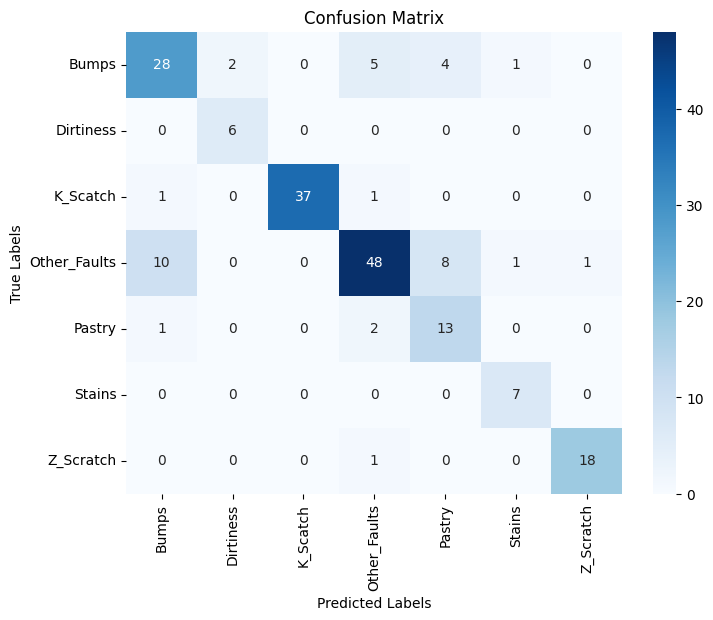

In [98]:
plot_confusion_matrix(y, pred_labels, y)

Dos resultados acima, parece que temos uma perfomance bastante respeitável. Também notamos que as classes que mais apresentam confusão entre si são Other_Faults, Bumps e Pastry, o que é corroborado pela nossa visualização na seção 3.3.